In [14]:
import numpy as np
from tensorflow import keras
from keras import layers

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import sys
np.set_printoptions(threshold=sys.maxsize)

from pythonosc import udp_client

epoch_step = 0

In [15]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_c1 = x_train[(y_train == 1)[:,0]][:50].reshape(50, -1)
x_c9 = x_train[(y_train == 9)[:,0]][:50].reshape(50, -1)

print(y_train.shape)

x_100 = np.concatenate([x_train[(y_train == 1)[:,0]][:50], x_train[(y_train == 9)[:,0]][:50]])
print((x_100).shape)


x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


(50000, 1)
(100, 32, 32, 3)
x_train shape: (50000, 32, 32, 3, 1)
50000 train samples
10000 test samples


In [16]:
# scale pixels
def prep_pixels(train, test):
	train_norm = train.astype('float32') / 255
	test_norm = test.astype('float32') / 255

	return train_norm, test_norm

In [17]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),  
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),  
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),  
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(20, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 


 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 20)                81940     
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 147718 (577.02 KB)
Trainable params: 147718 (577.02 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [18]:
class outs1(keras.callbacks.Callback):

    def on_train_begin(self, epoch, logs=None):
        global epoch_step
        epoch_step = 1
    
    def on_epoch_end(self, epoch, logs=None):
        global epoch_step
        epoch_step += 1

    def on_batch_end(self, batch, logs={}):          
        
        from keras import backend as K
        from IPython.display import clear_output
        #clear_output(wait=True)

        if batch % 20 == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(1,5)


            inp = model.input
            outputs = [layer.output for layer in model.layers]
            functors = [K.function([inp], [out]) for out in outputs]
            
            test = np.random.random(input_shape)[np.newaxis,...]
            
            layer_outs_1 = [func([x_test[0][np.newaxis,...]]) for func in functors]
            layer_outs_2 = [func(x_100) for func in functors]
            

            #x_100_flattened = layer_outs_2[7][0][:,:,:,:].reshape(100,-1)
            x_100_flattened = layer_outs_2[-2][0]
            metric = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric[i,j] = np.linalg.norm(x_100_flattened[i] - x_100_flattened[j])

                    #metric[i,j] = np.dot(x_100_flattened[i], x_100_flattened[j])
            
            #print(layer_outs_2[7][0].shape)
            x_100_flattened_2 = layer_outs_2[-1][0]
            #x_100_flattened_2 = layer_outs_2[7][0][:,:,:,:].reshape(100,-1)
            metric_2 = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric_2[i,j] = np.linalg.norm(x_100_flattened_2[i] - x_100_flattened_2[j])
            
            
            a = np.sum(metric_2[:50,:50]) / 50**2
            b = np.sum(metric_2[:50,50:]) / 50**2
            c = np.sum(metric_2[50:,:50]) / 50**2
            d = np.sum(metric_2[50:,50:]) / 50**2

            e = b - a
            f = c - d

            print('\n', e, f)

            x_100_flattened_3 = layer_outs_2[0][0]
            metric_3 = np.zeros((100, 100))
            for i in range(100):
                for j in range(100):
                    metric_3[i,j] = np.linalg.norm(x_100_flattened_3[i] - x_100_flattened_3[j])
            

            axes[0].imshow(x_test[0], cmap='viridis')
            axes[1].imshow(layer_outs_1[0][0][0,:,:,0], cmap='viridis')
            axes[2].imshow(metric, cmap='viridis')
            axes[3].imshow(metric_2, cmap='viridis')
            axes[4].imshow(metric_3, cmap='viridis')
            
            # for x in range (5):
            #     axes[x].set_xticks([])
            #     axes[x].set_yticks([])  

            plt.show()

            #print(np.sum(np.argmax(layer_outs_2[8][0][:50], axis=1) == 1), np.sum(np.argmax(layer_outs_2[8][0][50:], axis=1) == 9))



 0.5417067350083031 0.5610468766149134


KeyboardInterrupt: 

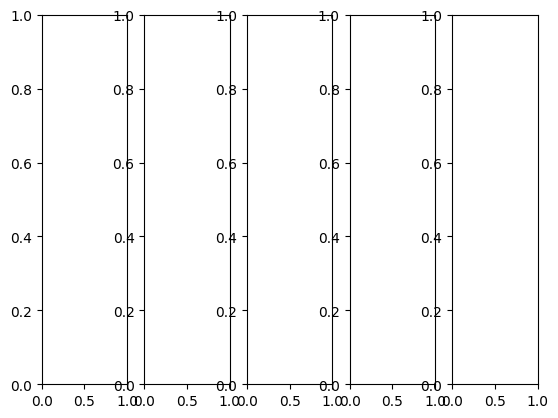

In [19]:
callbacks_list = [outs1()]


batch_size = 64
epochs = 10
optimizer = keras.optimizers.Adam()

model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks_list)
